# HTGAA 2026: Opentrons Artwork Lab
*By Eyal Perry, Laura Maria Gonzalez, Dominika Wawrzyniak, Alex Hadik, Suvin Sundararajan, Ronan Donovan*

This notebook contains a few examples that demonstrates how the Opentrons OT-2 can be used to draw arbitrary patterns using the the Python [Opentrons API](https://docs.opentrons.com/v2/new_atomic_commands.html). These examples can and should be used as your template as you try to pattern your own colorful, synthetically engineered bacteria.

To use this, **make your own copy** of this Colab (using the "Copy to Drive" button near the top of this Colab, or similarly File&rarr;Save a copy in Drive).  In your copy click the "Run All" button near the top, then edit the last section with your own code.  Your work will be saved in your copy.

Note: After learning about how to program designs using colab and python, you may choose to print more designs with automated tools like [Opentrons Art Interface](https://opentrons-art.rcdonovan.com).


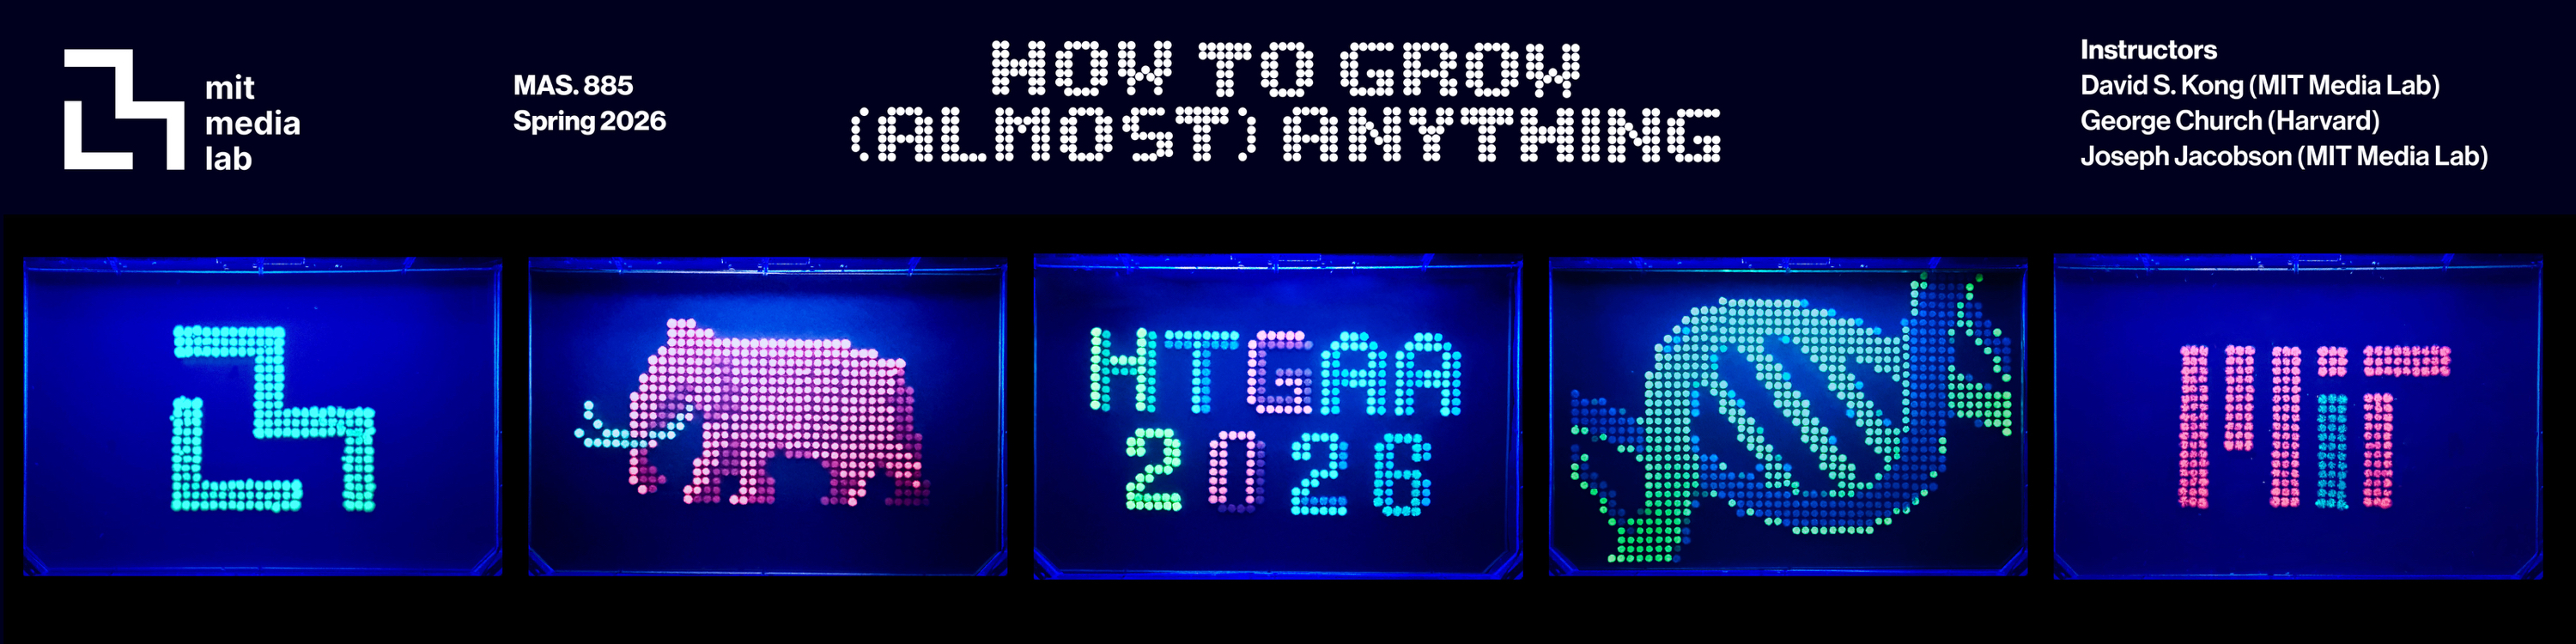

Each example consists of two blocks of code:
1. The **first code block** is where the pattern is drawn using `.aspirate()`, `.move_to()`, and `dispense_and_detach()` (as a wrapper around `.dispense()`) commands (similar to G-code). This block will typically generate no output, as it's just loading the code (but doesn't run it yet).  This block of code can later be copied as-is and saved as a `.py` file to be executed on a real Opentrons machine.
2. The **second code block** runs a simple simulation that visualizes the pipetted pattern by executing your code in the simulator in this colab. This block will draw the state of the plate after running the robot code.

At the end is a section for you to code your design in, with the same two code blocks.  Make your own copy of this Colab notebook and work in your copy.  When ready, upload the link to your first block in this section to the linked [google form](https://docs.google.com/forms/d/e/1FAIpQLScy0WLb-l3SnSzSFs8idvcPG7SgPpIRngpaPvbpsNZrVolWDQ/viewform) a day before your lab date!  Don't edit the second block in this section, as only the first block will be run on the robot.

## **Several important notes**:
- All units are in *mm*
- **Never go beyond a radius of 40mm from (0,0)**. If you do, you might hit the walls of the petri dish and all hell breaks loose, or you might dispense onto the wall of or even outside the petri dish.  (Some common "90mm" or "100mm" petri dishes only have an inner diameter of 84mm in the bottom plate, and the tip occupies a radius of a couple mm.)
- For the Black Agar Plates, dispense 1 uL drops by default.  (If you are trying for a particular effect, going slightly higher in some places may be acceptable.)  While that may sound like a small quantity, the E.coli will still be visible (especially after growing) and small “pixel” sizes can produce more detailed patterns.
- Be careful of dispensing samples too close to each other! They will move around slightly depending on the size of the drop.  1uL drops 2mm apart may sometimes run together or may stay mostly distinct even after incubation; 1uL drops 5mm apart will almost always stay distinct, but give you less than half the "resolution" for your art.  Midway between those - 3.5mm separation - may be a happy medium.  (See past year photos here and in the Lab Protocol and count dots along one axis; these of course show the ones which were lucky enough to mostly not run together...)
- On the robot if you dispense and immediately move the tip 1cm to the left it will create a streak of bio-ink (shaped according to the viscosity of the liquid).  The simulator accounts for this basic effect, and you will see spurious lines between your dots or to random locations in the visualization.  We have provided a routine `dispense_and_detach()` that dispenses and moves the tip slightly up & down to fully clear the droplet; you can use this in your code both for the simulator and the robot to avoid streaking.
- We have defined standard configuration for the robot deck for this lab, and our template code follows it.  We plan to have Red-, Yellow-, Green-, Cyan-, and Blue-fluorescing bacteria (but no others) at all sites in the robot for your use, and have provided a routine `location_of_color()` you can use to retrieve our standardized configuration's location of a named color (which you can pass to an aspirate() call).
- Pay attention to any text output from the simulator (typically just above the plate image) - it can give useful diagnostics and statistics.  Don't get so focused on your beautiful drawing that you forget to check this every once and a while.
- Remember not to waste any resources (here tips & reagents, as explained in [the Lab Protocol](https://docs.google.com/document/d/1VR1ngrwncH4kW80PHKZDGITu4GJbDa7pCE9yCs4YdUU/edit?tab=t.0#heading=h.hbaevt9v4nks) -- you can confirm via the "Volume Totals by Color"  and "Tip Count" summaries shown after every successful run -- but don't cross-contaminate your color wells.
- The visualization is not 100% accurate. We don't model any flud dynamics, so any streaking if you don't use `dispense_and_detach()`, any effects of dispensing from z>0, and even the droplet sizes in all cases are not physically realistic; and the simulator doesn't have an awareness of the 3D positions of labware.  (Feel free to contribute improvements to the simulator!)
- The simulation is not even close to a 100% complete reimplementation of the Opetrons API. Some commands will work on the OT-2 but will cause errors in the simulation (Feel free to contribute!).

### After your code is done, to submit it to be run on a robot:
1. Make sure your code is accessible to us: in your colab click the "Share" icon in the upper right, set "General access" so that "Anyone with the link" can be a "Viewer".
1. Copy to the clipboard a link to your code: right-click in the [**first code block**](#scrollTo=pczDLwsq64mk) (which has the `metadata = {...}` section near the top and your code at the end) and choose "Copy link to cell"
1. Paste this URL into the [Google form for submitting](https://docs.google.com/forms/d/e/1FAIpQLScy0WLb-l3SnSzSFs8idvcPG7SgPpIRngpaPvbpsNZrVolWDQ/viewform) to the OT-2 and submit **at least a day before** your robot time slot.
1. Review [the Instructions](https://docs.google.com/document/d/1VR1ngrwncH4kW80PHKZDGITu4GJbDa7pCE9yCs4YdUU/edit?tab=t.0#heading=h.hbaevt9v4nks) given in the Lab Protocol.

# Prerequisite Code

The following block of code contains required installations and the simulation/visualization code. It only needs to be run once per runtime.

When run, it will output errors declaring "<font color="darkred">ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.</font>" and list some package incompatibilities; that is expected, and is a result of the Opentrons API requiring an old version of some libraries.  (No other errors are expected.)

This block can be re-run in a runtime without ill effect (but will show the same errors every time).

In [17]:
#@title Run this block once per runtime to set up your environment
## The colab now comes with too new a version of numpy; opentrons still needs an older one.
## So set up venv-like isolation of my pip installs (separated from colab packages) for all subsequent cells.
## (Without doing this, colab would require restarting the runtime right after installing a different numpy version.)
import sys, os
py = f"{sys.version_info.major}.{sys.version_info.minor}"
PKG = f"/content/venv/lib/python{py}/site-packages"
# os.makedirs(PKG, exist_ok=True)
if PKG not in sys.path: sys.path.insert(0, PKG)
os.environ["PIP_TARGET"] = PKG     # routes `!pip` / `%pip` installs into the venv
os.environ["PYTHONNOUSERSITE"] = "1"

# Install opentrons into the venv (and all its dependencies!) BEFORE any `import numpy` etc.
%pip install -q --upgrade --target "$PKG" opentrons

## Now opentrons has been cleanly installed in its own venv-like environment with
## versions of packages it likes; proceed to use it "normally" from here.
from opentrons import types
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


# Petri dish size constants
PETRI_INNER_DIAMETER = 84   # 84mm is hopefully a tight lower bound on inner diameter of "90mm" & "100mm" petri dishes
MAX_DRAW_RADIUS = PETRI_INNER_DIAMETER/2 - 2   # leave 2mm margin for the tip size, drop size, miscalibration, etc.


####
#### Define some classes for our custom HTGAA Opentrons simulator/visualizer
####

nullLocation = types.Location(types.Point(x=250, y=250, z=250), None)

def same2DLocation(loc1, loc2):     # ignores z (=> tests x, y, and labware)
    return loc1.point.x == loc2.point.x and loc1.point.y == loc2.point.y and loc1.labware == loc2.labware

def mock_print(str):
    #print("...\n" + str)
    pass

# Map fluorescent protein names to matplotlib-compatible display colors
PROTEIN_COLOR_MAP = {
    'mrfp1': 'red', 'mturquoise2': 'turquoise', 'azurite': 'royalblue',
    'electra2': 'cyan', 'mko2': 'orange', 'mscarlet_i': 'crimson',
    'mjuniper': 'darkgreen', 'mclover3': 'limegreen', 'mwasabi': 'lightgreen',
    'venus': 'gold', 'sfgfp': 'lime', 'mkate2_tf': 'deeppink',
    'mcerulean3': 'deepskyblue', 'mbanana': 'khaki', 'mplum': 'plum',
    'mpapaya': 'peachpuff', 'eqfp578': 'coral', 'tdtomato': 'tomato',
    'dsred': 'darkred', 'mkate2': 'hotpink', 'egfp': 'lime',
    'mruby2': 'firebrick', 'tagbfp': 'mediumblue', 'mchartreuse_tf': 'chartreuse',
    'mlychee_tf': 'lightcoral', 'mtagbfp2': 'blue', 'megfp': 'lime',
    'mneongreen': 'springgreen', 'mazamigreen': 'mediumseagreen',
    'mwatermelon': 'lightpink', 'avgfp': 'yellowgreen', 'mcitrine': 'yellow',
    'mvenus': 'gold', 'mcherry': 'darkred', 'hotpink': 'hotpink',
    'tagrfp': 'orangered', 'mtfp1': 'mediumturquoise', 'ultramarine': 'midnightblue',
    'zsgreen1': 'mediumspringgreen', 'mmicy': 'paleturquoise',
    'mstaygold2': 'goldenrod', 'pa_gfp': 'palegreen',
}

# each PipetteSim instance tracks what it's dispensed; if you have multiple, need to call visualize() on each.
# (can't unify multiple by making the instance variables into class variables; note this colab has at least
#  one instance per example, and we don't want those sharing dispense states.)
class PipetteSim:   # modeled after InstrumentContext in the opentrons api
  def __init__(self, instrument_official_name, mount_LR, tip_rack_list, well_colors):
    if instrument_official_name != "p20_single_gen2":
      raise ValueError(f"Unsupported pipette {instrument_official_name} -- should be p20_single_gen2")
    self.max_volume = 20
    self.instrument_official_name = instrument_official_name

    if mount_LR != "right":
      raise ValueError(f"Unsupported pipette mount {mount_LR} -- should be right")
    self.mount_LR = mount_LR

    if tip_rack_list[0].labware_official_name != "opentrons_96_tiprack_20ul":
      raise ValueError(f"Unsupported tip rack {tip_rack_list[0].labware_official_name} -- should be opentrons_96_tiprack_20ul")
    self.tip_rack_list = tip_rack_list

    self.well_colors = well_colors
    self.droplets_x = []
    self.droplets_y = []
    self.droplets_size = []
    self.droplets_color = []
    self.smears = []                # list of 3-tuples: (xlist, ylist, color)
    self.location = nullLocation    # used by dispense_and_detach()
    self.justDispensedAt = None
    self.current_volume = 0
    self.aspirated_loc = None
    self.totalAspirated = {}        # 'color' : total
    self.totalDispensed = {}        # 'color' : total
    self.curr_color = 'orange'
    self.has_tip = False            # (in the opentrons api!)
    self.tip_count = 0

  def __del__(self):
    if self.has_tip:
      raise Exception("### ERROR: Run completed without dropping the tip!") # python prints but ignores exceptions in destructors

  def _display_color(self, color):
    """Translate a protein/color name to a matplotlib-compatible color."""
    c = color.lower()
    if c == 'green':
      return 'lime'
    return PROTEIN_COLOR_MAP.get(c, color)

  # used by our dispense_and_detach() routine
  def _get_last_location_by_api_version(self):  # (in the opentrons api!)
    return self.location

  # use the well id to make up a location on the petri dish diagram:
  # D6 in the center, A1 lower left, H12 upper right (assuming 96-well, but will work for any)
  def petriLocOfWell(self, well):   # (NOT in opentrons api)
    assert(isinstance(well, WellMock))
    x,y = well.get_row_col()
    return well.top().move(types.Point(x=(x-ord('D')) * MAX_DRAW_RADIUS/4,
                                       y=(y-6) * MAX_DRAW_RADIUS/6,
                                       z=0))

  # but no smear if it's just a z-move
  def smearIfJustDispensed(self, loc):  # (NOT in opentrons api)
    assert(isinstance(loc, (types.Location, WellMock)))
    if self.justDispensedAt is not None:
      newloc = loc if isinstance(loc, types.Location) else self.petriLocOfWell(loc)
      if not same2DLocation(self.justDispensedAt, newloc):
        line_end = self.justDispensedAt.move(0.5 * (newloc.point - self.justDispensedAt.point))
        self.smears.append(([self.justDispensedAt.point.x, line_end.point.x],
                            [self.justDispensedAt.point.y, line_end.point.y],
                            self._display_color(self.curr_color)))
    self.justDispensedAt = None

  def dispense(self, volume, location): # (in opentrons api)
    assert(isinstance(location, types.Location)) # not allowing dispensing into well or trashbin/wastechute for this lab -- petri only!
    assert(isinstance(volume, (int, float)))
    if (location.point.x**2 + location.point.y**2 > MAX_DRAW_RADIUS**2):
      raise ValueError(f'Dispensing outside "safe" area: Point ({location.point.x}, {location.point.y}) is more than' +
                       f" {MAX_DRAW_RADIUS}mm away from the petri dish's center.")
    if not self.has_tip:
      raise RuntimeError("dispense() called when no tip was being held")
    if self.current_volume < volume:
      raise ValueError(f"You dispensed {volume}uL, which is more than was in the pipette ({self.current_volume}uL).")
    if volume <= 0:
      raise ValueError(f"Dispensing {volume}uL -- you should dispense a positive amount.")
    if location.point.z < 0:
      raise ValueError(f"dispense() passed a location with z={location.point.z} -- do not go below z=0!")
    if location.point.z >= 10:
      print(f"Dispensing from a location with z={location.point.z} -- do you really want to dispense from that high?")
    self.smearIfJustDispensed(location)
    self.current_volume -= volume
    self.droplets_x.append(location.point.x)
    self.droplets_y.append(location.point.y)
    self.droplets_size.append(volume * 100)     # unprincipled scale factor (1uL->100 sq.pt), but it works
    self.droplets_color.append(self._display_color(self.curr_color))
    self.totalDispensed.setdefault(self.curr_color, 0)
    self.totalDispensed[self.curr_color] += volume
    self.location = location
    self.justDispensedAt = location

  def aspirate(self, volume, location):     # (in opentrons api)
    assert(isinstance(volume, (int, float)))
    assert(isinstance(location, (types.Location, WellMock)))
    if not self.has_tip:
      raise RuntimeError("aspirate() called when no tip was being held")
    if volume + self.current_volume > self.max_volume:
      raise ValueError(f"Aspirating {volume}uL + {self.current_volume}uL already in pipette = {volume + self.current_volume}uL,"
                       f" which is more than the pipette can hold ({self.max_volume}uL).")
    if volume <= 0:
      raise ValueError(f"Aspirating {volume}uL -- you should aspirate a positive amount.")
    if self.aspirated_loc is not None and self.aspirated_loc != location:
      raise RuntimeError(f"Cross-contaminating wells {self.aspirated_loc} and {location} with a single pipette")
    self.aspirated_loc = location
    self.smearIfJustDispensed(location)
    self.current_volume += volume
    if isinstance(location, WellMock):
      if location.well_id.upper() not in (id.upper() for id in self.well_colors.keys()):
        raise ValueError(f"aspirate() was passed well location {location} which hasn't been configured to have a color.")
      color = location.color()
      newloc = location
    else:   # legal for aspirate() but we should probably treat this as an error for this lab?  right now marking it white...
      print(f"WARNING -- aspirate() passed a Location rather than a well -- are you sure you know what you're doing?")
      if location.point.z < 0:
        raise ValueError(f"aspirate() passed a location with z={location.point.z} -- do not go below z=0!")
      color = 'white'     # we don't know where they're asiprateing from... use an unusual color to mark it.
      newloc = self.petriLocOfWell(location)
    self.curr_color = color
    self.totalAspirated.setdefault(color, 0)
    self.totalAspirated[color] += volume
    self.location = newloc

  def pick_up_tip(self):            # (in opentrons api)
    loc = types.Location(types.Point(x=-MAX_DRAW_RADIUS, y=MAX_DRAW_RADIUS, z=0), 'Pickup Tip')
    self.smearIfJustDispensed(loc)
    if self.has_tip:
      raise RuntimeError("pick_up_tip() called when already holding a tip")
    self.has_tip = True
    assert(self.aspirated_loc is None)
    self.tip_count += 1
    self.current_volume = 0
    self.location = loc

  def drop_tip(self):               # (in opentrons api)
    loc = types.Location(types.Point(x=MAX_DRAW_RADIUS, y=MAX_DRAW_RADIUS, z=0), 'Drop Tip')
    self.smearIfJustDispensed(loc)
    if not self.has_tip:
      raise RuntimeError("drop_tip() called when no tip was being held")
    self.has_tip = False
    self.aspirated_loc = None
    self.current_volume = 0
    self.location = loc

  def move_to(self, location):      # (in opentrons api)
    if location.point.z < 0:
      raise ValueError(f"move_to() passed a location with z={location.point.z} -- do not go below z=0!")
    self.smearIfJustDispensed(location)
    self.location = location

  def visualize(self):              # (NOT in opentrons api)
    print("\n=== VOLUME TOTALS BY COLOR ===")
    for color in self.totalAspirated.keys() | self.totalDispensed.keys():
      comment = ''
      if self.totalAspirated.setdefault(color, 0) != self.totalDispensed.setdefault(color, 0):
        comment = "\t\t##### WASTING BIO-INK : more aspirated than dispensed!"
      print(f"\t{color}:\t\t aspirated {self.totalAspirated[color]}\t dispensed {self.totalDispensed[color]}{comment}")
    print(f"\t[all colors]:\t[aspirated {sum(self.totalAspirated.values())}]\t[dispensed {sum(self.totalDispensed.values())}]")
    print(f"\n=== TIP COUNT ===\n\t Used {self.tip_count} tip(s)  (ideally exactly one per unique color)")
    print("\n") # plus prints its own newline

    ## uncomment (only) one of these corresponding to the background medium you're printing on
    plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#000000', fill=True)) # petri dish - 84mm inner diam, black agar plate
    #plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#000000', fill=False)) # petri dish - 84mm inner diam, paper insert
    #plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#d7ca95', fill=True)) # petri dish - 84mm inner diam, agar plate

    plt.scatter(self.droplets_x, self.droplets_y, self.droplets_size, c=self.droplets_color)

    for xlist,ylist,color in self.smears:
        plt.gca().plot(xlist, ylist, color=color, linewidth=4, solid_capstyle='round')

    plt.xlim((-(PETRI_INNER_DIAMETER/2 + 0.5), PETRI_INNER_DIAMETER/2 + 0.5))
    plt.ylim((-(PETRI_INNER_DIAMETER/2 + 0.5), PETRI_INNER_DIAMETER/2 + 0.5))
    plt.show()


class WellMock:
    def __init__(self, well_id, well_color, labware_official_name):
        self.well_id = well_id
        self.labware_official_name = labware_official_name
        self.well_color = well_color if well_color else 'purple'

    def get_row_col(self):          # (NOT in opentrons api)
        row = ord(self.well_id[0].upper())
        col = int(self.well_id[1:])
        return (row, col)

    def set_row_col(self, row, col):# (NOT in opentrons api)
        self.well_id = chr(row) + str(col)

    def color(self):                # (NOT in opentrons api)
        return self.well_color

    def bottom(self, z):            # (in opentrons api)
        assert z >= 0
        return self

    def center(self):               # (in opentrons api)
        return self

    def top(self, z=0):             # (in opentrons api)
        assert(isinstance(z, (int, float)))
        return types.Location(types.Point(x=0, y=0, z=z), 'Well')
        # return self

    def move(self, location):       # (NOT in opentrons api) -- why do we have this here? what do we think it should do, move a well?
        assert(isinstance(location, types.Location))
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.__dict__ == other.__dict__

    def __repr__(self):
        return self.well_id



class LabwareMock:
    def __init__(self, labware_official_name, deck_slot, display_name, well_colors):
        self.labware_official_name = labware_official_name
        self.deck_slot = deck_slot
        self.display_name = display_name
        self.well_colors = well_colors

    # the opentrons api names these arguments: self, idx
    def well(self, well_id):        # (in opentrons api, but deprecated -- use wells(int) or wells_by_name(str) instead)
        return WellMock(well_id, self.well_colors.get(well_id, ''), self)

    def __getitem__(self, well_id):
        return WellMock(well_id, self.well_colors.get(well_id, ''), self)

    def __repr__(self):
        return "Deck Slot %s - %s" % (str(self.deck_slot), self.display_name)

    def set_offset(self, x=0, y=0, z=0):   # no-op in simulation
        pass


class ModuleMock:
    def __init__(self, module_official_name, deck_slot, well_colors):
        self.module_official_name = module_official_name
        self.deck_slot = deck_slot
        self.well_colors = well_colors

    # the opentrons api names these arguments: self, name, label
    def load_labware(self, labware_official_name, display_name):    # (in opentrons api)
        mock_print("Module " + str(self.module_official_name) + " loaded " + str(labware_official_name))
        return LabwareMock(labware_official_name, self.deck_slot, display_name, well_colors)

    def set_temperature(self, celsius):     # (in opentrons api)
        assert(isinstance(celsius, int))
        assert(celsius >= 4 and celsius <= 110)
        mock_print("Setting temperature to " + str(celsius) + "C")

    def open_lid(self):                     # (in opentrons api)
        mock_print("Opening lid")

    def close_lid(self):                    # (in opentrons api)
        mock_print("Closing lid")

    def set_lid_temperature(self, temperature):     # (in opentrons api, but only for Thermocycler)
        assert(isinstance(temperature, int))
        assert(temperature >= 4 and temperature <= 110)
        mock_print("Setting lid temperature to " + str(temperature) + "C")

    def deactivate_lid(self):               # (in opentrons api, but only for Thermocycler)
        mock_print("Deactivate lid")

                                            # (in opentrons api, but only for Thermocycler)
    def set_block_temperature(self, temperature, hold_time_minutes=0, hold_time_seconds=0, ramp_rate=0, block_max_volume=25):
        assert(isinstance(temperature, int))
        assert(temperature >= 4 and temperature <= 110)
        assert(isinstance(hold_time_minutes, int))
        assert(isinstance(block_max_volume, int))
        mock_print("Setting block temperature to " + str(temperature) + "C")
        if (hold_time_minutes > 0):
            mock_print("Holding for " + str(hold_time_minutes) + " minutes...")
        if (hold_time_seconds > 0):
            mock_print("Holding for " + str(hold_time_seconds) + " seconds...")

    def execute_profile(self, steps, repetitions, block_max_volume):    # (in opentrons api, but only for Thermocycler)
        assert(isinstance(repetitions, int))
        assert(isinstance(block_max_volume, int))

        mock_print("Executing following protocol for " + str(repetitions) + " cycles")

        for step in steps:
            assert(isinstance(step, dict))
            assert(isinstance(step['temperature'], int))
            assert(isinstance(step['hold_time_seconds'], int))

            mock_print("Temperature: " + str(step['temperature']) + "C, Time: " + str(step['hold_time_seconds']) + " seconds")


# hmm, this appears to be unused...
class InstrumentMock:
    def __init__(self, instrument_official_name, mount_LR, tip_rack_list):
        self.instrument_official_name = instrument_official_name
        self.mount_LR = mount_LR
        starting_tip = None

        if "p20" in instrument_official_name:
            self.display_name = "P20"
            self.vol_range = (1, 20)
        elif "p300" in instrument_official_name:
            self.display_name = "P300"
            self.vol_range = (20, 300)
        elif "p1000" in instrument_official_name:
            self.display_name = "P1000"
            self.vol_range = (100, 1000)
        else:
            mock_print("WARNING: UNSUPPORTED PIPETTE")
            assert false

    def advance_tip(self):
        row, col = self.starting_tip.get_row_col()

        row += 1
        if row > ord('H'):
            row = ord('A')
            col += 1

        if col > 12:
            mock_print("WARNING: OUT OF TIPS!!!")
            assert false

        self.starting_tip.set_row_col(row, col)

    def pick_up_tip(self):
        row, col = self.starting_tip.get_row_col()
        assert(row >= ord('A') and row <= ord('H'))
        assert(col >= 1 and col <= 12)
        mock_print(self.display_name + " is picking up a tip from " + str(self.starting_tip))
        self.advance_tip()

    def drop_tip(self):
        mock_print(self.display_name + " is dropping a tip");

    def aspirate(self, volume, well):
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] ---> (" + str(volume) + "uL)")

    def dispense(self, volume, well):
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] <--- (" + str(volume) + "uL)")

    def blow_out(self):
        mock_print(self.display_name + " blow out")

    def mix(self, repetitions, volume, well):
        assert(isinstance(repetitions, int))
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] - Mixing - " + str(repetitions) + " times, volume " + str(volume) + "uL")

    def move_to(self, location, force_direct=False):
        assert(isinstance(force_direct, bool))
        assert(isinstance(location, WellMock))
        mock_print(self.display_name + " is moving");


class OpentronsMock:
    def __init__(self, well_colors):
        self.well_colors = well_colors
        self.pipette = None
        #self.location_cache = None     # unimplemented: opentrons api's more canonical way to get last_location, but these protocols don't need it

    def home(self):
        mock_print("Going home!")

    # the opentrons api names these arguments: self, load_name, location, label
    def load_labware(self, labware_official_name, deck_slot, display_name=''):
        mock_print("Loaded " + str(labware_official_name) + " in deck slot " + str(deck_slot))
        return LabwareMock(labware_official_name, deck_slot, display_name, self.well_colors)

    # the opentrons api names these arguments: self, module_name, location
    def load_module(self, module_official_name, deck_slot=0):
        mock_print("Loaded module " + str(module_official_name) + " in deck slot " + str(deck_slot))
        return ModuleMock(module_official_name, deck_slot, self.well_colors)

    # the opentrons api names these arguments: self, instrument_name, mount, tip_racks
    def load_instrument(self, instrument_official_name, mount_LR, tip_rack_list):
        self.pipette = PipetteSim(instrument_official_name, mount_LR, tip_rack_list, self.well_colors)
        return self.pipette

    def pause(self):
        mock_print("Robot pause")

    def visualize(self):
        self.pipette.visualize()


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/req_command.py", line 96, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/commands/install.py", line 503, in run
    self._handle_target_dir(
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3

# Example 1: Array of Dots

A simple array of dots of the same color. Notice that the units are in *mm*.

In [2]:
from opentrons import types

metadata = {
    'protocolName': 'HTGAA Opentrons Lab',
    'author': 'HTGAA',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  # In this example, we will create an array of dots, and streak the last dot using move_to

  # Aspirate
  pipette_20ul.pick_up_tip()
  pipette_20ul.aspirate(16, location_of_color('Green'))

  # Pattern a 1uL dot array
  for i in range(4):
    for j in range(4):
      # Get a location i*5 mm right, j*5 mm up from the center of the plate.
      adjusted_location = center_location.move(types.Point(x=i*5, y=j*5))

      dispense_and_detach(pipette_20ul, 1, adjusted_location)

  # Clean up!
  pipette_20ul.drop_tip()


=== VOLUME TOTALS BY COLOR ===
	Green:		 aspirated 16	 dispensed 16
	[all colors]:	[aspirated 16]	[dispensed 16]

=== TIP COUNT ===
	 Used 1 tip(s)  (ideally exactly one per unique color)




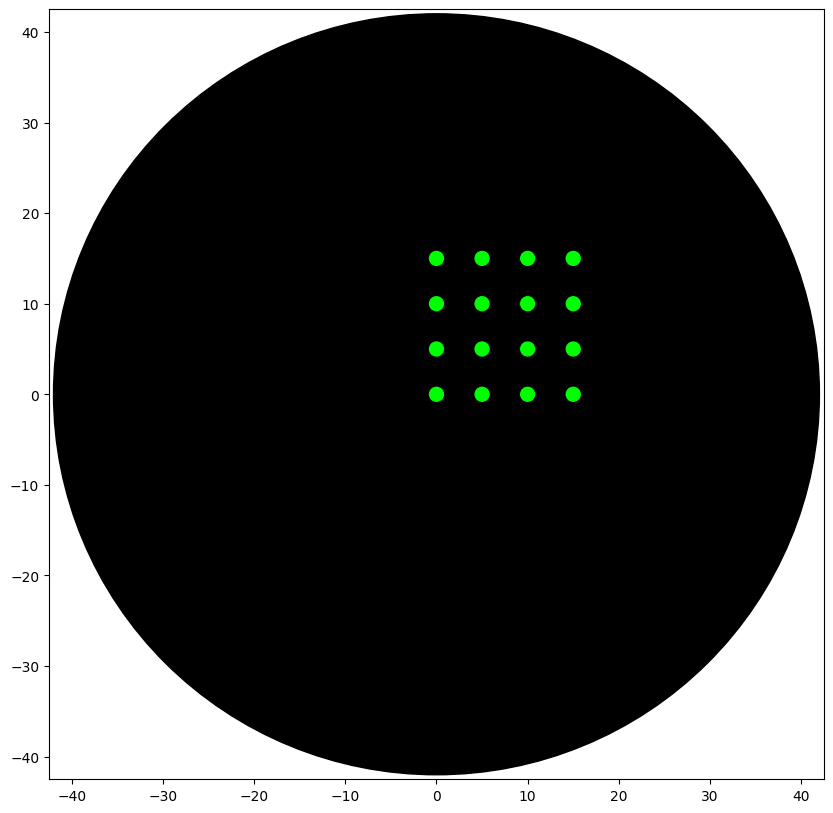

In [3]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

# Example 2: Circle of increasing volumes

This example draws a circle dispensing progressively larger volumes, 1uL through 20uL, centers spaced about 6.25mm apart.

Note that 1uL drops will give the highest "resolution" images and will always be a good default volume to use.

Remember that the visualization here is only illustrative and is not entirely representative of what you would see on an agar plate.  Drop sizes are not to scale, especially after incubation/growing the E.coli; and larger drops are unlikely to appear round or even to stay where they're put.

In [4]:
from opentrons import types
import math

metadata = {    # see https://docs.opentrons.com/v2/tutorial.html#tutorial-metadata
    'author': '',
    'protocolName': '',
    'description': '',
    'source': 'HTGAA 2026 Opentrons Lab',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  radius = 20

  pipette_20ul.pick_up_tip()

  for i in range(20):
    radians = i * 2*math.pi / 20
    adjusted_location = center_location.move(types.Point(x=radius*math.cos(radians), y=radius*math.sin(radians)))
    pipette_20ul.aspirate(i+1, location_of_color('cyan'))
    dispense_and_detach(pipette_20ul, i+1, adjusted_location)

  # Don't forget to end with a drop_tip()
  pipette_20ul.drop_tip()


=== VOLUME TOTALS BY COLOR ===
	Cyan:		 aspirated 210	 dispensed 210
	[all colors]:	[aspirated 210]	[dispensed 210]

=== TIP COUNT ===
	 Used 1 tip(s)  (ideally exactly one per unique color)




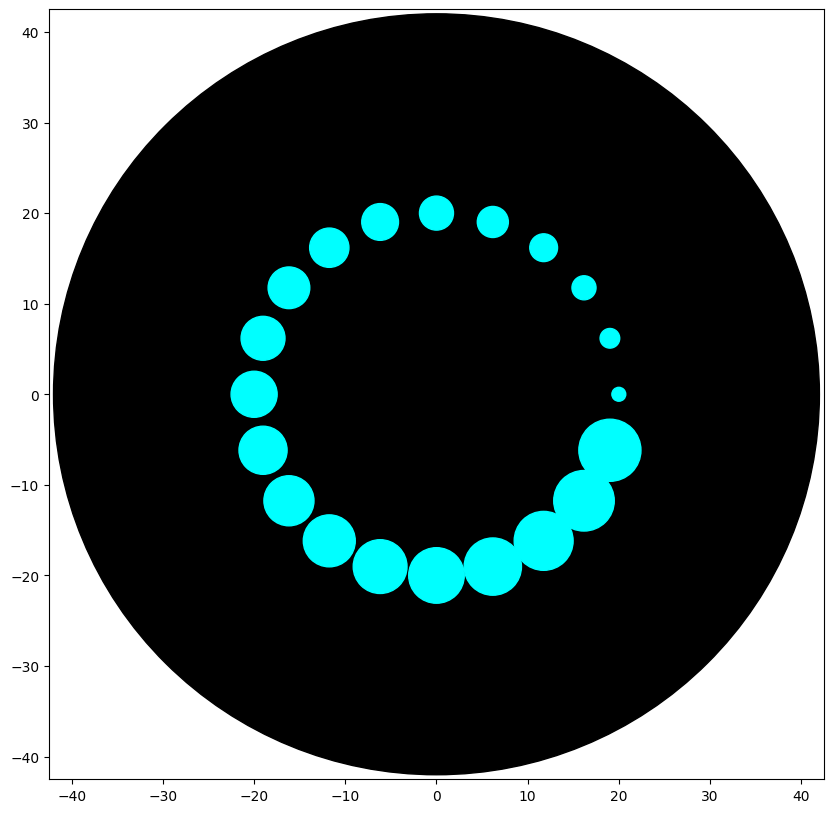

In [5]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

del math    # unimport imported modules so blocks lower in the colab have a clean slate (like they would on the robot)

# Example 3: Mathematical Heart
*by [Selin Sahin, 2023 student](https://nutritious-molybdenum-2e5.notion.site/Week-03-Opentrons-Fluorescent-Art-bcdde86011fa4da79b405c3bc3f9c6e2)*

This example first generates a list of points using a [parametric equation for a heart](https://mathworld.wolfram.com/HeartCurve.html#:~:text=A%20fifth%20heart%20curve%20can%20be%20defined%20parametrically%20as) and then uses it to do the appropriate robot control.

In [6]:
from opentrons import types
import math

metadata = {
    'protocolName': 'Selin - HTGAA Robotic Patterning',
    'author': 'HTGAA',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  def heart_pattern(n, r, color_string, center_location):
    # generate list of points forming the heart
    scaling_factor = -2/r  # calculate scaling factor to fit pattern within 40mm radius circle
    angle_step = 2*math.pi/n
    coords = []
    for i in range(n):
        angle = i * angle_step
        x = scaling_factor*r*(16*math.sin(angle)**3)
        y = scaling_factor*(-r*(13*math.cos(angle) - 5*math.cos(2*angle) - 2*math.cos(3*angle) - math.cos(4*angle)))
        coords.append((x, y))

    ####PICK UP TIP HERE####
    pipette_20ul.pick_up_tip()

    print_every = 2     # 1=print every point; 2=print every other point; 3=print every third...

    # now plot the points
    for i, (x,y) in enumerate(coords):
        #print(i,(x,y))
        if i % (20*print_every) == 0:
            # every 20th point we're printing starting with the first, aspirate 20uL total from Well 1
            pipette_20ul.aspirate(min(20, math.ceil((len(coords)-i)/print_every)), location_of_color(color_string))
        # print every other point we've calculated (was too dense otherwise)
        if i % print_every == 0:
            adjusted_location = center_location.move(types.Point(x, y))
            dispense_and_detach(pipette_20ul, 1, adjusted_location)

    ####DROP TIP####
    pipette_20ul.drop_tip()

  ##################################
  #### DRAW PATTERN ####
  ##################################

  heart_pattern(100, 50, 'Red', center_location)


=== VOLUME TOTALS BY COLOR ===
	Red:		 aspirated 50	 dispensed 50
	[all colors]:	[aspirated 50]	[dispensed 50]

=== TIP COUNT ===
	 Used 1 tip(s)  (ideally exactly one per unique color)




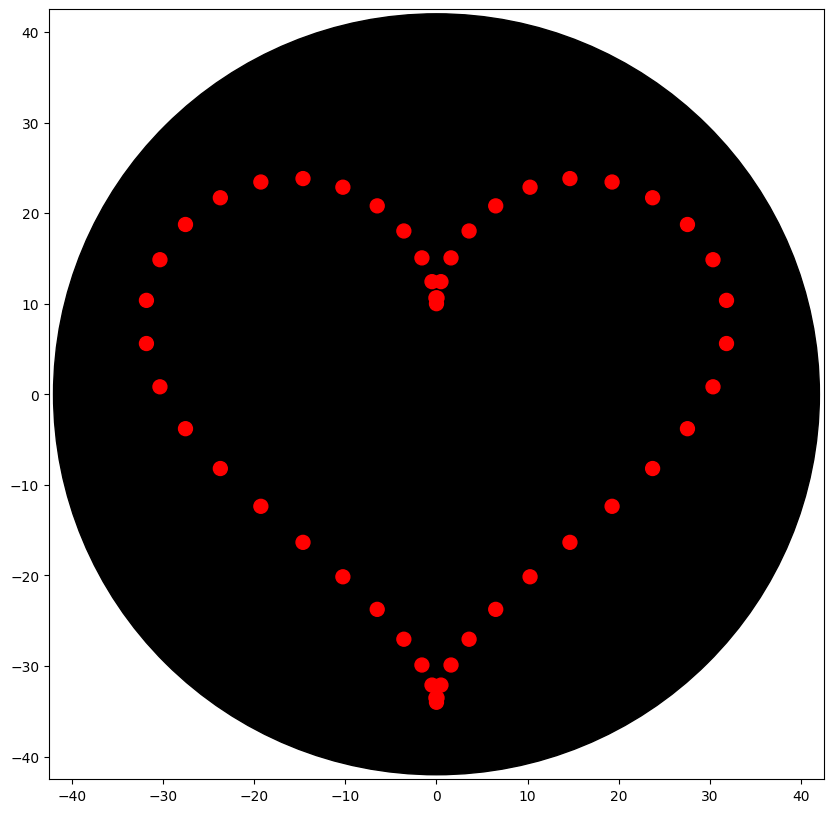

In [7]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

del math    # unimport imported modules so blocks lower in the colab have a clean slate (like they would on the robot)

# Example 4: Phyllotaxis

*By Laura Maria Gonzalez, HTGAA 2022 TA*

In this example, a pretty pattern is generated by by simple mathematical function which models [*phyllotaxis*](https://en.wikipedia.org/wiki/Phyllotaxis) (from the Greek for "leaf arrangement") using [Fermat's spiral](https://en.wikipedia.org/wiki/Fermat%27s_spiral).

In [8]:
from opentrons import types
import math

metadata = {
    'protocolName': 'HTGAA Opentrons Lab',
    'author': 'HTGAA',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  ##################################
  #### PATTERN ####
  ##################################
  def phyllo_pattern(n, angle, color_string, center_location):
    n=n*4
    c=2.2
    count = 0
    branch = 0
    branch_count = 0
    c1 = []
    c1_a = [] #branch a
    c1_b = [] #branch b
    c1_c = [] #branch c
    c1_d = [] #branch d

    while n>0:
      a=n*math.degrees(angle)
      r=c*math.sqrt(n)
      x1=r*math.cos(a)
      y1=r*math.sin(a)

      #only taking every other branch to form a four branch pattern
      if count%2==0:
        c1.append(tuple((x1,y1)))
      n-=1
      count+=1

    for x,y in c1:
      if branch==0:
        c1_a.append(tuple((x,y)))
        branch+=1
      elif branch==1:
        c1_b.append(tuple((x,y)))
        branch+=1
      elif branch==2:
        c1_c.append(tuple((x,y)))
        branch+=1
      elif branch==3:
        c1_d.append(tuple((x,y)))
        branch-=3

    ####PICK UP TIP HERE####
    pipette_20ul.pick_up_tip()
    ####ASPIRATE####
    pipette_20ul.aspirate(20, location_of_color(color_string))
    #20uL total from Well 1
    for x,y in c1_a:
      if branch_count%2==0:
        adjusted_location = center_location.move(types.Point(x, y))
        dispense_and_detach(pipette_20ul, 1, adjusted_location)
      branch_count+=1
    print(c1_a)

    ####ASPIRATE####
    pipette_20ul.aspirate(20, location_of_color(color_string))
    #20uL total from Well 1
    for x,y in c1_b:
      if branch_count%2==0:
        adjusted_location = center_location.move(types.Point(x, y))
        dispense_and_detach(pipette_20ul, 1, adjusted_location)
      branch_count+=1

    ####ASPIRATE####
    pipette_20ul.aspirate(20, location_of_color(color_string))
    #20uL total from Well 1
    for x,y in c1_c:
      if branch_count%2==0:
        adjusted_location = center_location.move(types.Point(x, y))
        dispense_and_detach(pipette_20ul, 1, adjusted_location)
      branch_count+=1

    ####ASPIRATE####
    pipette_20ul.aspirate(20, location_of_color(color_string))
    #20uL total from Well 1
    for x,y in c1_d:
      if branch_count%2==0:
        adjusted_location = center_location.move(types.Point(x, y))
        dispense_and_detach(pipette_20ul, 1, adjusted_location)
      branch_count+=1

    ####DROP TIP####
    pipette_20ul.drop_tip()

  ##################################
  #### DRAW PATTERN ####
  ##################################

  phyllo_pattern(80,287, 'yellow', center_location)
  phyllo_pattern(80,-287,'blue', center_location)


[(-27.917789078897076, 27.738007371587013), (-25.90403995576935, 28.96654473646979), (-23.83972645322404, 30.05041501602682), (-21.734993114076225, 30.987579355784785), (-19.60007237942212, 31.776676395139468), (-17.445242219399926, 32.417025216797214), (-15.28078379200737, 32.90862571882827), (-13.116939781722122, 33.252156182158714), (-10.963873025167343, 33.4489684188916), (-8.831626082584933, 33.501080292095146), (-6.7300818102655695, 33.41116578072565), (-4.668925096302671, 33.182542676008346), (-2.6576062305856807, 32.819157958776955), (-0.7053058635392362, 32.325571048921276), (1.1790980322592548, 31.706935011607833), (2.987060767322281, 30.968975894793875), (4.710399063323584, 30.117970394172318), (6.341316081425064, 29.160722047909925), (7.872423076828277, 28.10453619790623), (9.296756917871608, 26.957194045560577), (10.60779306394943, 25.726926095288313), (11.799453013052545, 24.422385399316855), (12.866105004844231, 23.052621152578773), (13.8025567067598, 21.627053159334498)

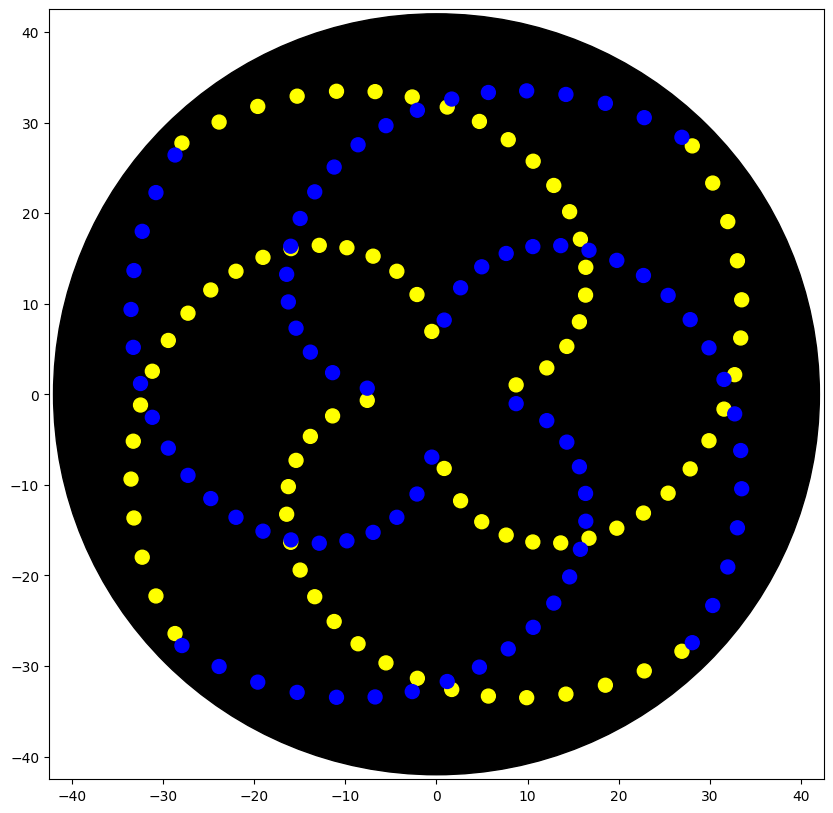

In [9]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

del math    # unimport imported modules so blocks lower in the colab have a clean slate (like they would on the robot)

# Example 5: HTGAA

*by Eyal Perry, 2021-2023 TA*

In this example, letters are "manually" generated.

In [10]:
from opentrons import types

metadata = {
    'protocolName': 'HTGAA Opentrons Lab',
    'author': 'HTGAA',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  # H
  cursor = center_location.move(types.Point(x=-35.5, y = 12))

  pipette_20ul.pick_up_tip()

  pipette_20ul.aspirate(20, location_of_color('Red'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    if i == 9:
      pipette_20ul.aspirate(10, location_of_color('Red'))
    cursor = cursor.move(types.Point(y =-2))

  cursor = cursor.move(types.Point(x=4, y=14))

  for i in range(3):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=-2)))
    cursor = cursor.move(types.Point(x =2))

  cursor = cursor.move(types.Point(y=10))

  pipette_20ul.aspirate(20, location_of_color('Red'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =-2))

    if i == 9:
      pipette_20ul.aspirate(4, location_of_color('Red'))

  cursor = cursor.move(types.Point(x=4, y=24))

  pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  # T
  pipette_20ul.aspirate(16, location_of_color('Yellow'))
  for i in range(8):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=-2)))
    cursor = cursor.move(types.Point(x =2))

  cursor = cursor.move(types.Point(x=-10, y=-4))

  pipette_20ul.aspirate(20, location_of_color('Yellow'))
  for i in range(10):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =-2))

  pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  # G
  cursor = cursor.move(types.Point(x=10, y=2))

  pipette_20ul.aspirate(20, location_of_color('Green'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =2))

    if i == 9:
      pipette_20ul.aspirate(14, location_of_color('Green'))

  cursor = cursor.move(types.Point(x=4, y=-2))

  for i in range(5):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=-2)))
    cursor = cursor.move(types.Point(x =2))


  cursor = cursor.move(types.Point(x=-4, y=-12))

  pipette_20ul.aspirate(18, location_of_color('Green'))

  for i in range(6):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y=-2))

  cursor = cursor.move(types.Point(x=-2, y=4))

  for i in range(3):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=-2)))
    cursor = cursor.move(types.Point(x =-2))

  # A

  pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  cursor = cursor.move(types.Point(x=12, y=-2))

  pipette_20ul.aspirate(20, location_of_color('Cyan'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =2, x=0.4))

    if i == 9:
      pipette_20ul.aspirate(4, location_of_color('Cyan'))

  cursor = cursor.move(types.Point(x=2, y=-2))

  pipette_20ul.aspirate(20, location_of_color('Cyan'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =-2, x=0.4))

    if i == 9:
      pipette_20ul.aspirate(4, location_of_color('Cyan'))

  cursor = cursor.move(types.Point(x=4, y=2))

  # A

  pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =2, x=0.4))

    if i == 9:
      pipette_20ul.aspirate(4, location_of_color('Blue'))

  cursor = cursor.move(types.Point(x=2, y=-2))

  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    cursor = cursor.move(types.Point(y =-2, x=0.4))

    if i == 9:
      pipette_20ul.aspirate(4, location_of_color('Blue'))

  pipette_20ul.drop_tip()


=== VOLUME TOTALS BY COLOR ===
	Cyan:		 aspirated 48	 dispensed 48
	Red:		 aspirated 54	 dispensed 54
	Green:		 aspirated 52	 dispensed 52
	Blue:		 aspirated 48	 dispensed 48
	Yellow:		 aspirated 36	 dispensed 36
	[all colors]:	[aspirated 238]	[dispensed 238]

=== TIP COUNT ===
	 Used 5 tip(s)  (ideally exactly one per unique color)




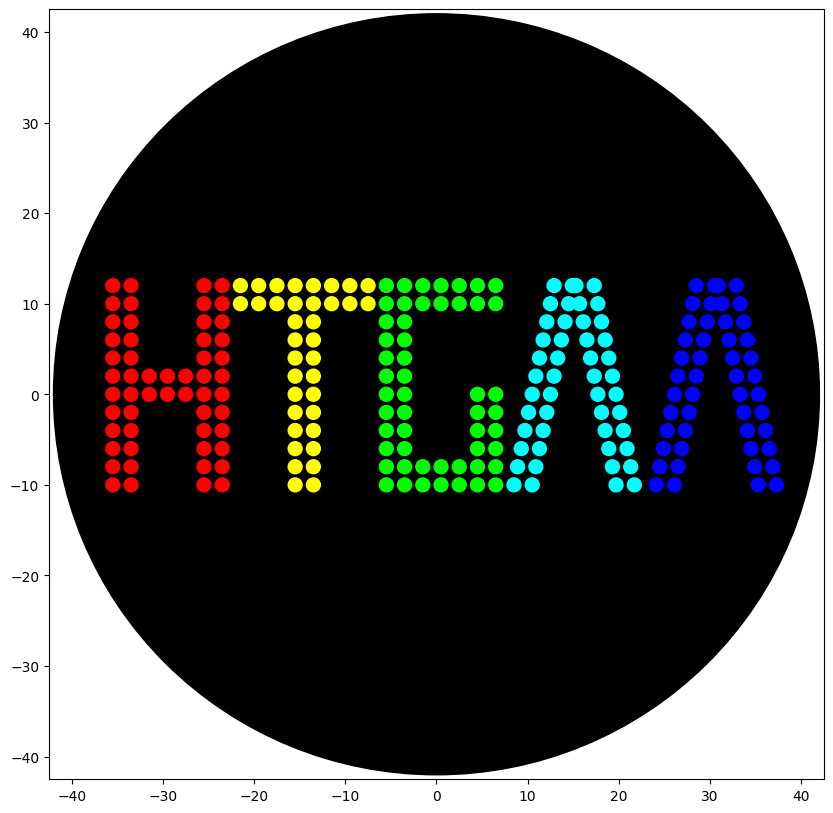

In [11]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

# Example 6: Double Helix
*by [Kevin Dunnell, 2023 student](https://diligent-jitterbug-db5.notion.site/Week-3-Lab-Automation-Opentrons-2b313a506581414abf9ccd1a9f66ace3)*

Kevin manipulated the example code provided for the [“HTGAA” logo example](#scrollTo=5x1LWb1jlurz) above to make a DNA double helix.  Here is the final product under natural & UV light:

<img width="50%" src="https://diligent-jitterbug-db5.notion.site/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fb72d87ae-0463-4116-95df-c7c1430d592b%2FIMG_4046.jpg?table=block&id=046d6497-cab3-4d58-8538-1478f52b08f8&spaceId=5cfff396-5767-431b-be35-0ea8fd2b6172&width=1420&userId=&cache=v2"><img width="50%" src="https://diligent-jitterbug-db5.notion.site/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F7738e39f-73e3-4102-b3b3-46780766f82f%2FIMG_4143.jpg?table=block&id=f242bdea-5a6e-4919-bf89-6560ba4838e8&spaceId=5cfff396-5767-431b-be35-0ea8fd2b6172&width=1420&userId=&cache=v2">

In [12]:
from opentrons import types

metadata = {
    'protocolName': 'HTGAA Robotic Patterning',
    'author': 'Kevin Dunnell',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_detach(pipette, 1, loc)
  def dispense_and_detach(pipette, volume, location):
      """
      Move laterally 5mm above the plate (to avoid smearing a drop); then drop down to the plate,
      dispense, move back up 5mm to detach drop, and stay high to be ready for next lateral move.
      5mm because a 4uL drop is 2mm diameter; and a 2deg tilt in the agar pour is >3mm difference across a plate.
      """
      assert(isinstance(volume, (int, float)))
      above_location = location.move(types.Point(z=location.point.z + 5))  # 5mm above
      pipette.move_to(above_location)       # Go to 5mm above the dispensing location
      pipette.dispense(volume, location)    # Go straight downwards and dispense
      pipette.move_to(above_location)       # Go straight up to detach drop and stay high

  ###
  ### YOUR CODE HERE to create your design
  ###

  startY = 34
  # halfStartY = int(startY/2)
  halfStartY = 17

  cursor = center_location.move(types.Point(x=-halfStartY, y = startY))

  #pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  # Helix - Top Left to Bottom Right
  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(17):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    if i == 9:
      pipette_20ul.aspirate(14, location_of_color('Blue'))
    cursor = cursor.move(types.Point(y =-2, x=0.1*i))

  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(17):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    if i == 9:
      pipette_20ul.aspirate(14, location_of_color('Blue'))
    cursor = cursor.move(types.Point(y =-2, x=0.1*(17-i)))

  # Helix - Top Right to Bottom Left
  cursor = cursor.move(types.Point(x=0, y=startY*2))

  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(17):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    if i == 9:
      pipette_20ul.aspirate(14, location_of_color('Blue'))
    cursor = cursor.move(types.Point(y =-2, x=-0.1*i))

  pipette_20ul.aspirate(20, location_of_color('Blue'))
  for i in range(17):
    dispense_and_detach(pipette_20ul, 1, cursor)
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(x=2)))
    if i == 9:
      pipette_20ul.aspirate(14, location_of_color('Blue'))
    cursor = cursor.move(types.Point(y =-2, x=-0.1*(17-i)))

  cursor = cursor.move(types.Point(x=4.25, y=startY*2-4))

  pipette_20ul.drop_tip()
  pipette_20ul.pick_up_tip()

  # Top Ladder

  pipette_20ul.aspirate(12, location_of_color('Red'))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=2)))
    cursor = cursor.move(types.Point(y =-.2, x=2))

  pipette_20ul.aspirate(11, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-22.5, y=-5))
  for i in range(11):
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=2, x=-.8)))
    cursor = cursor.move(types.Point(y =-.3, x=2))

  pipette_20ul.aspirate(8, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-19.5, y=-4))
  for i in range(8):
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=2, x=-.8)))
    cursor = cursor.move(types.Point(y =-.4, x=2))

  pipette_20ul.aspirate(4, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-11.5, y=-4.5))
  for i in range(4):
    dispense_and_detach(pipette_20ul, 1, cursor.move(types.Point(y=2, x=-1)))
    cursor = cursor.move(types.Point(y =-.5, x=2))

  #Bottom Ladder
  pipette_20ul.aspirate(12, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-16.5, y=-startY-3))
  for i in range(12):
    dispense_and_detach(pipette_20ul, 1, cursor)
    cursor = cursor.move(types.Point(y =.2, x=2))

  pipette_20ul.aspirate(10, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-22.25, y=5))
  for i in range(10):
    dispense_and_detach(pipette_20ul, 1, cursor)
    cursor = cursor.move(types.Point(y =.3, x=2))

  pipette_20ul.aspirate(7, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-17, y=4))
  for i in range(7):
    dispense_and_detach(pipette_20ul, 1, cursor)
    cursor = cursor.move(types.Point(y =.4, x=2))

  pipette_20ul.aspirate(3, location_of_color('Red'))
  cursor = cursor.move(types.Point(x=-10, y=4.5))
  for i in range(3):
    dispense_and_detach(pipette_20ul, 1, cursor)
    cursor = cursor.move(types.Point(y =.5, x=2))

  pipette_20ul.drop_tip()


=== VOLUME TOTALS BY COLOR ===
	Red:		 aspirated 67	 dispensed 67
	Blue:		 aspirated 136	 dispensed 136
	[all colors]:	[aspirated 203]	[dispensed 203]

=== TIP COUNT ===
	 Used 2 tip(s)  (ideally exactly one per unique color)




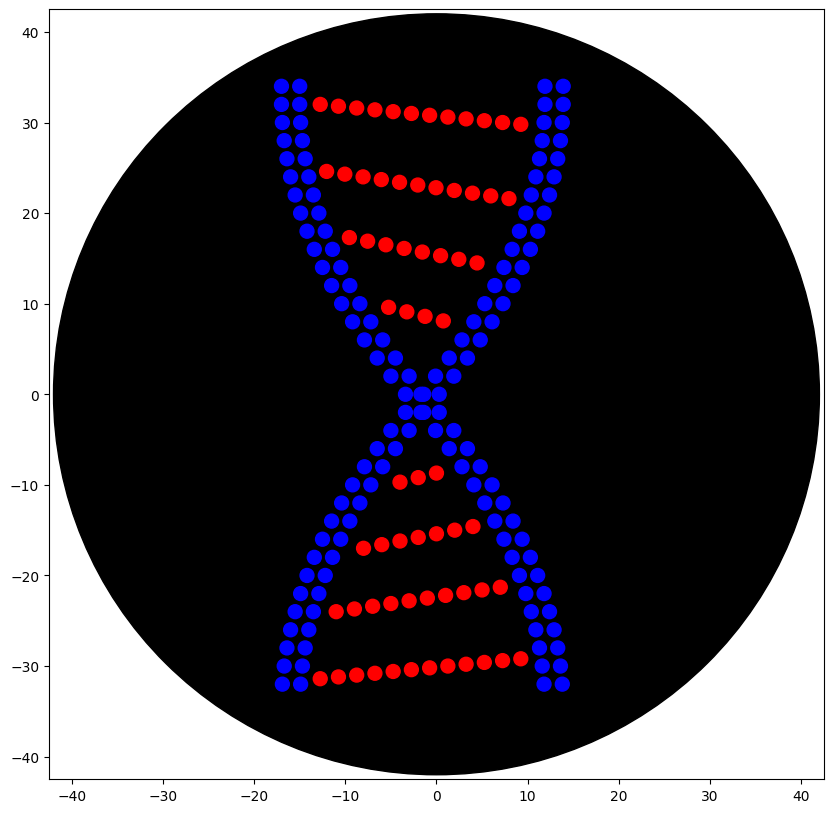

In [13]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

# Example 7: Microbial Earth

*By [Dominika Wawrzyniak, 2021 student](https://fluttering-algebra-675.notion.site/Week-4-Next-Generation-Synthesis-f028ea9c6c8946c4bfa85808f6864d29#08d657c0804643b39309def450a8e2d3) (and subsequent TA!)*

In this example, the pixels of the pattern are loaded from an external resource (CSV file hosted online).

(Note that this example uses dispense() directly and manages its own z-moves to ensure there's no steaking.)

To understand how Dominika transformed an image into an array of dots to pipette, read her [well documented Notion page from HTGAA21](https://www.notion.so/Week-4-Next-Generation-Synthesis-f028ea9c6c8946c4bfa85808f6864d29#08d657c0804643b39309def450a8e2d3).

Hope this inspires you to document well and support future HTGAA students :)


In [14]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy", "pandas"])
import numpy as np
import pandas as pd

from opentrons import types

metadata = {
    'protocolName': 'HTGAA Opentrons Lab',
    'author': 'HTGAA',
    'source': 'HTGAA 2022',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

# using nonstandard color setup - will not run on a robot with this lab's standard deck setup.
well_colors = {
    'F1' : 'hotpink'
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  input_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  #Gets the coordinates of my design, so that they can be read into the protocol
  url = 'https://raw.githubusercontent.com/Minikaw/Microbial_Earth_Coordinates/main/ResultsMicrobialWorld_final.csv'
  world_coord = pd.read_csv(url)
  data = world_coord
  data.columns = ["x", "y"]

  #Inverts the y-coordinates, else my design is upside-down
  y_inverted = np.amax(data['y'])-data['y']

  #Get min and max x-/y-values from my coordinates
  raw_x_min = np.amin(data['x'])
  raw_x_max = np.amax(data['x'])
  raw_y_min = np.amin(y_inverted)
  raw_y_max = np.amax(y_inverted)


  #Shift data, so that the centerpoint 0/0 is at the center of my design
  world_coord_x_shifted = data['x']-((raw_x_min + raw_x_max)/2)
  world_coord_y_shifted = y_inverted-((raw_y_min + raw_y_max)/2)

  all_distances_to_center = np.sqrt(np.square(world_coord_x_shifted) + np.square(world_coord_y_shifted));

  world_coord_x_85mm_shifted = 40/np.amax(all_distances_to_center)*world_coord_x_shifted;
  world_coord_y_85mm_shifted = 40/np.amax(all_distances_to_center)*world_coord_y_shifted;

  #Opentron Protocol for a pink microbial earth

  # Get the top-center of the plate, make sure the plate was calibrated before running this

  center_location = agar_plate['A1'].top()

  cell_well = input_plate['F1'] #Change to location of pink transformands

  # Aspirate
  pipette_20ul.pick_up_tip()

  for i in range(len(world_coord_x_85mm_shifted)):
    if i%20 == 0:
      # pick up more every 20 uL, but only as much as we're going to need!
      pipette_20ul.aspirate(min(20, len(world_coord_x_85mm_shifted)-i), cell_well)

    adjusted_location = center_location.move(types.Point(world_coord_x_85mm_shifted[i], world_coord_y_85mm_shifted[i]))
    pipette_20ul.dispense(1, adjusted_location)
    hover_location = adjusted_location.move(types.Point(z = 2))
    pipette_20ul.move_to(hover_location)

  pipette_20ul.drop_tip()

  Using cached numpy-2.4.2-cp311-cp311-macosx_14_0_x86_64.whl.metadata (6.6 kB)
  Using cached pandas-3.0.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (79 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.4.2-cp311-cp311-macosx_14_0_x86_64.whl (6.8 MB)
Using cached pandas-3.0.1-cp311-cp311-macosx_10_9_x86_64.whl (10.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]━━━━ 3/4 [pandas]dateutil]


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentrons 8.8.1 requires numpy<2,>=1.20.0, but you have numpy 2.4.2 which is incompatible.

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mozta/Documents/Majo/opentrons/venv/lib/python3.11/site-packages/pip/_internal/cli/req_command.py", line 96, in wrapper
    return func(self, options, a

CalledProcessError: Command '['/Users/mozta/Documents/Majo/opentrons/venv/bin/python', '-m', 'pip', 'install', 'numpy', 'pandas']' returned non-zero exit status 2.


=== VOLUME TOTALS BY COLOR ===
	hotpink:		 aspirated 201	 dispensed 201
	[all colors]:	[aspirated 201]	[dispensed 201]

=== TIP COUNT ===
	 Used 1 tip(s)  (ideally exactly one per unique color)




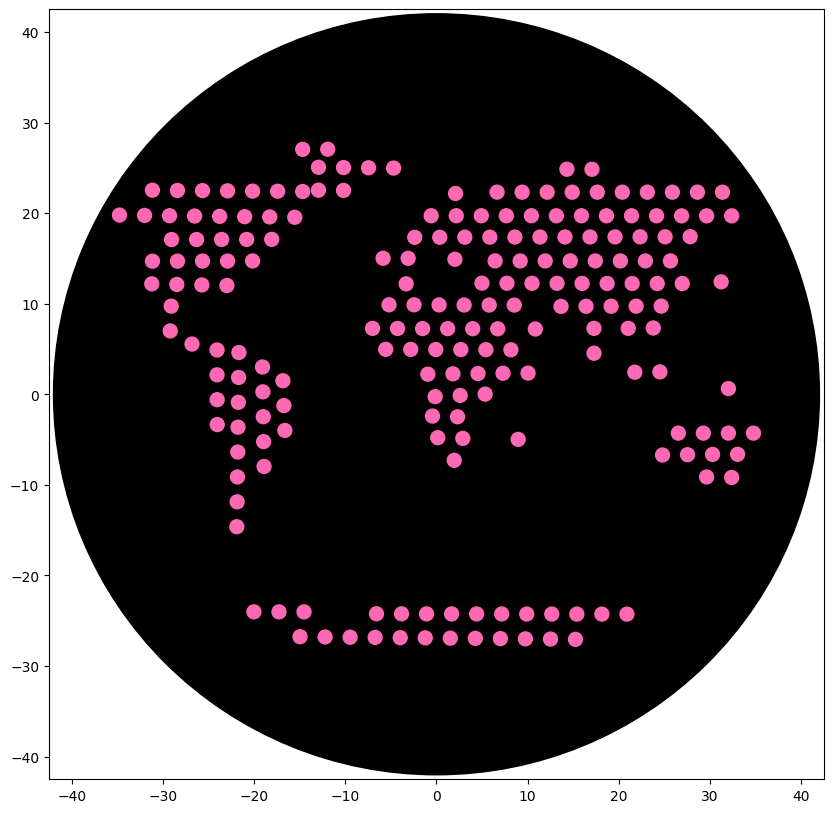

In [ ]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

del np, pd    # unimport imported modules so blocks lower in the colab have a clean slate (like they would on the robot)

# Your Code
* Put your name in the `'author'` field of the metadata near the top of the [first block](#scrollTo=pczDLwsq64mk), give your protocol a `'protocolName'` there, and fill in the `'description'` of what the protocol will do
* Write code to create your design at the very end of the [first block](#scrollTo=pczDLwsq64mk)

<br>

**DEVELOPMENT TIP:** Write your code in short runnable chunks, and after you've written each one run both of your clode blocks (running the first one loads your code, running the second one executes it on the simulator) to see that it's doing what you expect.  Simulate often!

In [18]:
from opentrons import types

import string

metadata = {
    'protocolName': '{YOUR NAME} - Opentrons Art - HTGAA',
    'author': 'HTGAA',
    'source': 'HTGAA 2026',
    'apiLevel': '2.20'
}

Z_VALUE_AGAR = 2.0
POINT_SIZE = 0.75

mrfp1_points = [(5.5,27.5), (7.7,27.5), (9.9,27.5), (12.1,27.5), (14.3,27.5), (16.5,27.5), (23.1,27.5), (7.7,25.3), (9.9,25.3), (12.1,25.3), (14.3,25.3), (16.5,25.3), (20.9,25.3), (23.1,25.3), (9.9,23.1), (20.9,23.1), (20.9,20.9), (18.7,18.7), (20.9,18.7), (1.1,16.5), (3.3,16.5), (5.5,16.5), (7.7,16.5), (9.9,16.5), (12.1,16.5), (18.7,16.5), (20.9,16.5), (1.1,14.3), (12.1,14.3), (20.9,14.3), (1.1,12.1), (12.1,12.1), (20.9,12.1), (23.1,12.1), (1.1,9.9), (12.1,9.9), (23.1,9.9), (1.1,7.7), (12.1,7.7), (1.1,5.5), (3.3,5.5), (5.5,5.5), (7.7,5.5), (9.9,5.5), (12.1,5.5), (-18.7,1.1), (-12.1,1.1), (-1.1,1.1), (-20.9,-1.1), (-14.3,-1.1), (-12.1,-1.1), (-3.3,-1.1), (-1.1,-1.1), (-23.1,-3.3), (-18.7,-3.3), (-16.5,-3.3), (-14.3,-3.3), (-12.1,-3.3), (-1.1,-3.3), (-25.3,-5.5), (-20.9,-5.5), (-18.7,-5.5), (-7.7,-5.5), (-3.3,-5.5), (-9.9,-7.7), (-5.5,-7.7), (9.9,-7.7), (-9.9,-9.9), (-7.7,-9.9), (-5.5,-9.9), (7.7,-9.9), (9.9,-9.9), (-12.1,-12.1), (-9.9,-12.1), (-5.5,-12.1), (-3.3,-12.1), (-1.1,-12.1), (1.1,-12.1), (3.3,-12.1), (5.5,-12.1), (7.7,-12.1), (9.9,-12.1), (-14.3,-14.3), (-12.1,-14.3), (-3.3,-14.3), (-1.1,-14.3), (1.1,-14.3), (3.3,-14.3), (5.5,-14.3), (7.7,-14.3), (-14.3,-16.5), (3.3,-16.5), (5.5,-16.5), (7.7,-16.5), (3.3,-18.7), (5.5,-18.7), (1.1,-20.9), (3.3,-20.9), (3.3,-23.1), (1.1,-25.3)]
mturquoise2_points = [(5.5,23.1), (7.7,23.1), (3.3,20.9), (5.5,20.9), (7.7,20.9), (9.9,20.9), (1.1,18.7), (5.5,18.7), (7.7,18.7), (9.9,18.7), (12.1,18.7), (-1.1,16.5), (14.3,16.5), (-3.3,14.3), (-1.1,14.3), (14.3,14.3), (16.5,14.3), (-3.3,12.1), (-1.1,12.1), (14.3,12.1), (16.5,12.1), (-7.7,9.9), (-5.5,9.9), (-3.3,9.9), (-1.1,9.9), (-12.1,7.7), (-7.7,7.7), (-5.5,7.7), (-3.3,7.7), (-1.1,7.7), (-7.7,5.5), (-5.5,5.5), (-3.3,5.5), (-1.1,5.5), (-9.9,3.3), (-7.7,3.3), (-5.5,3.3), (-3.3,3.3), (-1.1,3.3), (1.1,3.3), (3.3,3.3), (5.5,3.3), (7.7,3.3), (-9.9,1.1), (-7.7,1.1), (-5.5,1.1), (1.1,1.1), (3.3,1.1), (5.5,1.1), (7.7,1.1), (-9.9,-1.1), (-7.7,-1.1), (3.3,-1.1), (5.5,-1.1), (7.7,-1.1), (-9.9,-3.3), (-7.7,-3.3), (3.3,-3.3), (-1.1,-5.5), (-16.5,-7.7), (-14.3,-7.7), (-12.1,-7.7), (-3.3,-7.7), (-1.1,-7.7), (1.1,-7.7), (-16.5,-9.9), (-14.3,-9.9), (-12.1,-9.9), (-3.3,-9.9), (-1.1,-9.9), (1.1,-9.9), (-7.7,-12.1), (-9.9,-14.3), (-7.7,-14.3), (-5.5,-14.3), (-7.7,-16.5), (-5.5,-16.5)]
azurite_points = [(5.5,25.3), (3.3,23.1), (1.1,20.9), (-1.1,18.7), (-3.3,16.5), (-5.5,14.3), (-7.7,12.1), (-9.9,9.9), (20.9,9.9), (20.9,7.7), (23.1,7.7), (18.7,5.5), (20.9,5.5), (16.5,3.3), (18.7,3.3), (14.3,1.1), (16.5,1.1), (12.1,-1.1), (14.3,-1.1), (12.1,-3.3), (9.9,-5.5)]
electra2_points = [(3.3,25.3), (1.1,23.1), (-1.1,20.9), (-3.3,18.7), (-5.5,16.5), (-7.7,14.3), (-9.9,12.1), (-12.1,9.9)]
mko2_points = [(-16.5,-12.1), (-14.3,-12.1), (-18.7,-14.3), (-16.5,-14.3), (-18.7,-16.5), (-16.5,-16.5), (-12.1,-16.5), (-9.9,-16.5), (-20.9,-18.7), (-18.7,-18.7), (-16.5,-18.7), (-14.3,-18.7), (-12.1,-18.7), (-9.9,-18.7), (-20.9,-20.9), (-18.7,-20.9), (-16.5,-20.9), (-14.3,-20.9), (-12.1,-20.9), (-20.9,-23.1), (-18.7,-23.1), (-16.5,-23.1), (-14.3,-23.1), (-12.1,-23.1), (-23.1,-25.3), (-20.9,-25.3), (-18.7,-25.3), (-16.5,-25.3), (-23.1,-27.5), (-20.9,-27.5), (-25.3,-29.7), (-23.1,-29.7)]
mscarlet_i_points = [(23.1,29.7), (18.7,27.5), (20.9,27.5), (18.7,25.3), (12.1,23.1), (14.3,23.1), (16.5,23.1), (18.7,23.1), (23.1,23.1), (12.1,20.9), (14.3,20.9), (16.5,20.9), (18.7,20.9), (23.1,20.9), (14.3,18.7), (16.5,18.7), (23.1,18.7), (16.5,16.5), (23.1,16.5), (18.7,14.3), (23.1,14.3), (-14.3,5.5), (-12.1,5.5), (-16.5,3.3), (-14.3,3.3), (-12.1,3.3), (-16.5,1.1), (-14.3,1.1), (-18.7,-1.1), (-16.5,-1.1), (-20.9,-3.3), (-5.5,-3.3), (-3.3,-3.3), (-23.1,-5.5), (-16.5,-5.5), (-14.3,-5.5), (-12.1,-5.5), (-5.5,-5.5), (-7.7,-7.7), (9.9,-14.3), (1.1,-16.5), (9.9,-16.5), (1.1,-18.7), (7.7,-18.7), (5.5,-20.9), (1.1,-23.1)]
mjuniper_points = [(3.3,18.7), (-5.5,12.1), (18.7,12.1), (-9.9,7.7), (16.5,7.7), (18.7,7.7), (-9.9,5.5), (12.1,3.3), (-3.3,1.1), (-5.5,-1.1), (1.1,-1.1), (9.9,-1.1), (1.1,-3.3), (-9.9,-5.5), (1.1,-5.5), (3.3,-5.5)]
mclover3_points = [(14.3,9.9), (16.5,9.9), (14.3,7.7), (9.9,3.3), (12.1,1.1), (7.7,-3.3), (9.9,-3.3)]
mwasabi_points = [(18.7,9.9), (14.3,5.5), (16.5,5.5), (14.3,3.3), (9.9,1.1), (5.5,-3.3), (5.5,-5.5), (7.7,-5.5), (3.3,-7.7), (5.5,-7.7), (7.7,-7.7), (3.3,-9.9), (5.5,-9.9)]
venus_points = [(3.3,14.3), (5.5,14.3), (7.7,14.3), (9.9,14.3), (3.3,12.1), (5.5,12.1), (7.7,12.1), (9.9,12.1), (3.3,9.9), (5.5,9.9), (7.7,9.9), (9.9,9.9), (3.3,7.7), (5.5,7.7), (7.7,7.7), (9.9,7.7)]

point_name_pairing = [("mrfp1", mrfp1_points),("mturquoise2", mturquoise2_points),("azurite", azurite_points),("electra2", electra2_points),("mko2", mko2_points),("mscarlet_i", mscarlet_i_points),("mjuniper", mjuniper_points),("mclover3", mclover3_points),("mwasabi", mwasabi_points),("venus", venus_points)]

# Robot deck setup constants
TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

# Place the PCR tubes in this order
well_colors = {
    'A1': 'sfGFP',
    'A2': 'mRFP1',
    'A3': 'mKO2',
    'A4': 'Venus',
    'A5': 'mKate2_TF',
    'A6': 'Azurite',
    'A7': 'mCerulean3',
    'A8': 'mClover3',
    'A9': 'mJuniper',
    'A10': 'mTurquoise2',
    'A11': 'mBanana',
    'A12': 'mPlum',
    'B1': 'Electra2',
    'B2': 'mWasabi',
    'B3': 'mScarlet_I',
    'B4': 'mPapaya',
    'B5': 'eqFP578',
    'B6': 'tdTomato',
    'B7': 'DsRed',
    'B8': 'mKate2',
    'B9': 'EGFP',
    'B10': 'mRuby2',
    'B11': 'TagBFP',
    'B12': 'mChartreuse_TF',
    'C1': 'mLychee_TF',
    'C2': 'mTagBFP2',
    'C3': 'mEGFP',
    'C4': 'mNeonGreen',
    'C5': 'mAzamiGreen',
    'C6': 'mWatermelon',
    'C7': 'avGFP',
    'C8': 'mCitrine',
    'C9': 'mVenus',
    'C10': 'mCherry',
    'C11': 'mHoneydew',
    'C12': 'TagRFP',
    'D1': 'mTFP1',
    'D2': 'Ultramarine',
    'D3': 'ZsGreen1',
    'D4': 'mMiCy',
    'D5': 'mStayGold2',
    'D6': 'PA_GFP'
}

volume_used = {
    'mrfp1': 0,
    'mturquoise2': 0,
    'azurite': 0,
    'electra2': 0,
    'mko2': 0,
    'mscarlet_i': 0,
    'mjuniper': 0,
    'mclover3': 0,
    'mwasabi': 0,
    'venus': 0
}

def update_volume_remaining(current_color, quantity_to_aspirate):
    rows = string.ascii_uppercase
    for well, color in list(well_colors.items()):
        if color.lower() == current_color.lower():
            if (volume_used[current_color] + quantity_to_aspirate) > 250:
                # Move to next well horizontally by advancing row letter, keeping column number
                row = well[0]
                col = well[1:]
                
                # Find next row letter
                next_row = rows[rows.index(row) + 1]
                next_well = f"{next_row}{col}"
                
                del well_colors[well]
                well_colors[next_well] = color
                volume_used[current_color] = quantity_to_aspirate
            else:
                volume_used[current_color] += quantity_to_aspirate
            break

def run(protocol):
    # Load labware, modules and pipettes
    protocol.home()

    # Tips
    tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

    # Pipettes
    pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

    # Deep Well Plate
    temperature_plate = protocol.load_labware('nest_96_wellplate_2ml_deep', 6)

    # Agar Plate
    agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')
    agar_plate.set_offset(x=0.00, y=0.00, z=Z_VALUE_AGAR)

    # Get the top-center of the plate, make sure the plate was calibrated before running this
    center_location = agar_plate['A1'].top()

    pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)
    
    # Helper function (dispensing)
    def dispense_and_jog(pipette, volume, location):
        assert(isinstance(volume, (int, float)))
        # Go above the location
        above_location = location.move(types.Point(z=location.point.z + 2))
        pipette.move_to(above_location)
        # Go downwards and dispense
        pipette.dispense(volume, location)
        # Go upwards to avoid smearing
        pipette.move_to(above_location)

    # Helper function (color location)
    def location_of_color(color_string):
        for well,color in well_colors.items():
            if color.lower() == color_string.lower():
                return temperature_plate[well]
        raise ValueError(f"No well found with color {color_string}")

    # Print pattern by iterating over lists
    for i, (current_color, point_list) in enumerate(point_name_pairing):
        # Skip the rest of the loop if the list is empty
        if not point_list:
            continue

        # Get the tip for this run, set the bacteria color, and the aspirate bacteria of choice
        pipette_20ul.pick_up_tip()
        max_aspirate = int(18 // POINT_SIZE) * POINT_SIZE
        quantity_to_aspirate = min(len(point_list)*POINT_SIZE, max_aspirate)
        update_volume_remaining(current_color, quantity_to_aspirate)
        pipette_20ul.aspirate(quantity_to_aspirate, location_of_color(current_color))

        # Iterate over the current points list and dispense them, refilling along the way
        for i in range(len(point_list)):
            x, y = point_list[i]
            adjusted_location = center_location.move(types.Point(x, y))

            dispense_and_jog(pipette_20ul, POINT_SIZE, adjusted_location)
            
            if pipette_20ul.current_volume == 0 and len(point_list[i+1:]) > 0:
                quantity_to_aspirate = min(len(point_list[i:])*POINT_SIZE, max_aspirate)
                update_volume_remaining(current_color, quantity_to_aspirate)
                pipette_20ul.aspirate(quantity_to_aspirate, location_of_color(current_color))

        # Drop tip between each color
        pipette_20ul.drop_tip()


=== VOLUME TOTALS BY COLOR ===
	mWasabi:		 aspirated 9.75	 dispensed 9.75
	mRFP1:		 aspirated 75.75	 dispensed 75.0		##### WASTING BIO-INK : more aspirated than dispensed!
	Electra2:		 aspirated 6.0	 dispensed 6.0
	mJuniper:		 aspirated 12.0	 dispensed 12.0
	mKO2:		 aspirated 24.75	 dispensed 24.0		##### WASTING BIO-INK : more aspirated than dispensed!
	mScarlet_I:		 aspirated 35.25	 dispensed 34.5		##### WASTING BIO-INK : more aspirated than dispensed!
	Venus:		 aspirated 12.0	 dispensed 12.0
	Azurite:		 aspirated 15.75	 dispensed 15.75
	mClover3:		 aspirated 5.25	 dispensed 5.25
	mTurquoise2:		 aspirated 58.5	 dispensed 57.75		##### WASTING BIO-INK : more aspirated than dispensed!
	[all colors]:	[aspirated 255.0]	[dispensed 252.0]

=== TIP COUNT ===
	 Used 10 tip(s)  (ideally exactly one per unique color)




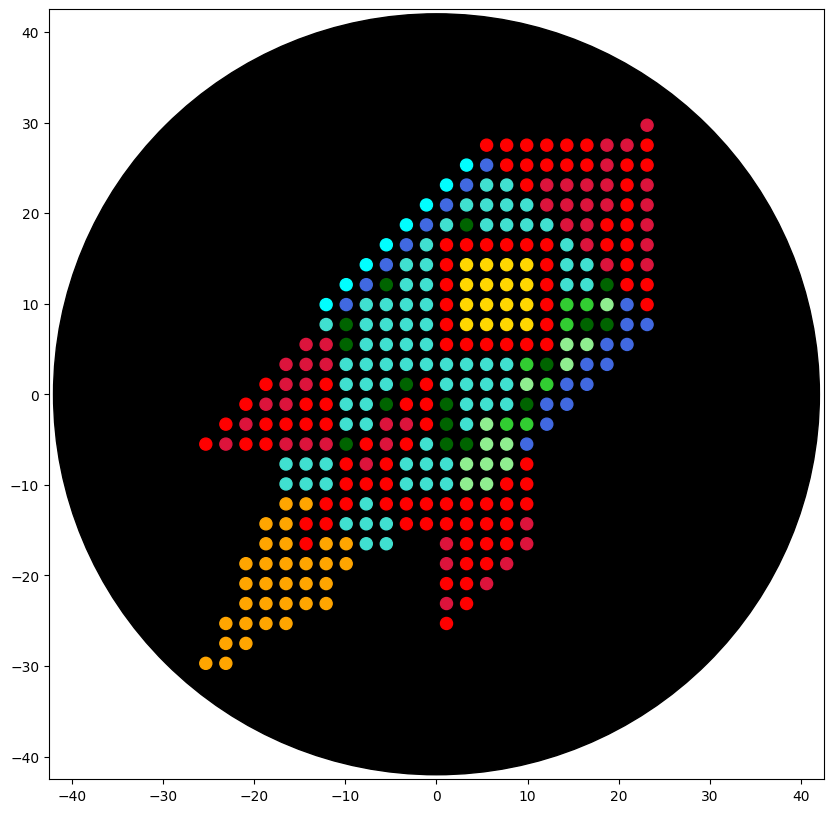

In [19]:
# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()

## Resumen

El codigo toma 10 listas de coordenadas (una por cada proteina fluorescente/color), y para cada una: toma una punta nueva, aspira bacterias del pozo correspondiente, deposita gotas de 0.75 uL en cada coordenada (x, y) sobre la placa de agar (re-aspirando cuando se vacia la pipeta), y suelta la punta antes de pasar al siguiente color. El resultado son ~336 puntos multicolores que, al incubar la placa, se convierten en arte biologico fluorescente.

### Cambios realizados al simulador para compatibilidad

Para que el protocolo (disenado para el robot real) funcionara en el simulador del notebook, se realizaron los siguientes ajustes en la celda del simulador/mock:

1. **`load_labware()` requeria 3 argumentos**, pero el codigo pasa solo 2. Se hizo el parametro `display_name` opcional con valor por defecto vacio.
2. **`set_offset()` no existia** en `LabwareMock`. Se agrego un metodo vacio (no-op).
3. **Los nombres de proteinas no son colores validos de matplotlib** (`'mRFP1'`, `'Venus'`...). Se creo un diccionario `PROTEIN_COLOR_MAP` que traduce cada proteina a un color compatible, y un metodo `_display_color()` en `PipetteSim`.
4. **Comparacion case-sensitive** en `update_volume_remaining()` (`'mRFP1' != 'mrfp1'`). Se cambio a comparacion case-insensitive usando `.lower()`.

**Nota:** Estos cambios solo afectan al simulador del notebook. El codigo del protocolo no fue modificado y corre sin cambios en el robot OT-2 real.